In [1]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import PILToTensor
from torch.utils.data import DataLoader
import numpy as np
import time

In [ ]:
root_dir = "/home/robertgshaw/images"
img_folder = ImageFolder(root=root_dir, transform=PILToTensor())
dl = DataLoader(img_folder, shuffle=True, batch_size=64)

In [ ]:
imgs_np = None
for batch in dl:
    if imgs_np is not None:
        imgs_np = np.concatenate((imgs_np, batch[0].numpy()), axis=0)
    else:
        imgs_np = batch[0].numpy()
    print(imgs_np.shape)
    if imgs_np.shape[0] == 512:
        break

In [ ]:
imgs_np = np.moveaxis(imgs_np, 1, -1)
print(imgs_np.shape)

In [ ]:
print(len(imgs_np.shape))

In [ ]:
np.save("imgs_np", imgs_np, allow_pickle=False)

In [2]:
# imgs = imgs_np
data = np.load("imgs_np.npy")

In [3]:
from benchmark_deepsparse import preprocess, postprocess
from concurrent.futures import ThreadPoolExecutor

In [4]:
from deepsparse import Engine

BATCH_SIZE = 16
compiled_model = Engine(
    model="zoo:cv/detection/yolov5-x6/pytorch/ultralytics/coco/pruned75_quant-none", 
    batch_size=BATCH_SIZE)

DeepSparse, Copyright 2021-present / Neuralmagic, Inc. version: 1.5.0.20230521 COMMUNITY | (074d79b5) (release) (optimized) (system=avx512_vnni, binary=avx512)


In [7]:
img_sz = 1280

if data.shape[1:3] != (img_sz,img_sz):
    original_shape = data.shape[1:3]
data_lst = list(data)

def get_batches(items):
    for i in range(0, len(items), BATCH_SIZE):
        yield items[i:i+BATCH_SIZE]

executor = ThreadPoolExecutor(max_workers=8)

start = time.perf_counter()
i = 0
for batch in get_batches(data):
    print(f"Batch = {i} / {len(data) // BATCH_SIZE}")
    engine_inputs = [preprocess(batch, executor, img_sz)]
    engine_outputs = compiled_model(engine_inputs)
    outputs = postprocess(engine_outputs, original_image_shape=original_shape, img_sz=img_sz)
    i+=1
end = time.perf_counter()

throughput = len(data) / (end-start)
print(f"Pipeline Throughput: {round(throughput,2)}")

Batch = 0 / 32
Batch = 1 / 32
Batch = 2 / 32
Batch = 3 / 32
Batch = 4 / 32
Batch = 5 / 32
Batch = 6 / 32
Batch = 7 / 32
Batch = 8 / 32
Batch = 9 / 32
Batch = 10 / 32
Batch = 11 / 32
Batch = 12 / 32
Batch = 13 / 32
Batch = 14 / 32
Batch = 15 / 32
Batch = 16 / 32
Batch = 17 / 32
Batch = 18 / 32
Batch = 19 / 32
Batch = 20 / 32
Batch = 21 / 32
Batch = 22 / 32
Batch = 23 / 32
Batch = 24 / 32
Batch = 25 / 32
Batch = 26 / 32
Batch = 27 / 32
Batch = 28 / 32
Batch = 29 / 32
Batch = 30 / 32
Batch = 31 / 32
Pipeline Throughput: 3.95


In [8]:
outputs[0]

[[],
 [],
 [],
 [[1345.329345703125,
   239.9784336090088,
   1923.6368408203125,
   1076.632209777832],
  [830.379638671875,
   525.667064666748,
   1400.2417602539062,
   1083.0349044799805]],
 [],
 [],
 [[1070.9696044921875, 5.97411847114563, 1239.0899047851562, 65.3466260433197],
  [1338.6653137207031, 1.0798444747924805, 1707.416015625, 730.3450355529785],
  [418.1220703125, 1.8024702072143555, 959.7874145507812, 513.9641532897949]],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

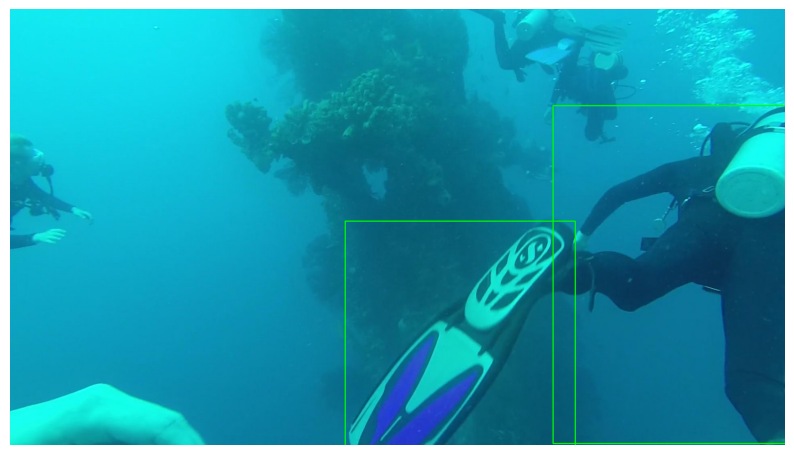

In [10]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

index = 3

plt.figure(figsize=(10, 10), facecolor='white')
im = batch[index]

for xmin, ymin, xmax, ymax in outputs[0][index]:
    start_point = (int(xmin), int(ymin))
    end_point = (int(xmax), int(ymax))
    color = (0, 255, 0)
    thickness = 2

    im = cv2.rectangle(im, start_point, end_point, color, thickness)

plt.axis("off")
plt.imshow(im)

In [ ]:
img_path = "/home/robertgshaw/imgs"